In [3]:
import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2


import random as rd

In [4]:
# Clean video
video=[]
cap = cv2.VideoCapture('escrime3.avi')
while(1):
   ret,frame=cap.read()
   video.append(frame)
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

In [5]:
# Create histogramme of given size centered in (x,y) from frame j of the video
def histoImage(x,y,size,video,j):
  image=video[j]
  histRed, b = np.histogram(image[x-size//2:x+size//2,y-size//2:y+size//2,0],255)
  histGreen, b = np.histogram(image[x-size//2:x+size//2,y-size//2:y+size//2,1],255)
  histBlue, b = np.histogram(image[x-size//2:x+size//2,y-size//2:y+size//2,2],255)
  histtot = np.concatenate((histRed,histGreen,histBlue),axis=0)
  histtot =  histtot/sum(histtot)
  return(histtot)

In [6]:
# create N particles with standard deviation sigma and mean (x,y) and carefully move points outside of the frame
def create_particles(N,x,y,sig,taille_carré):
    L=np.random.multivariate_normal((x,y),sig,N)
    L=np.round(L).astype(int)
    L[L<taille_carré//2]=taille_carré//2
    L[:,0][L[:,0]>480-taille_carré//2]=480-taille_carré//2
    L[:,1][L[:,1]>640-taille_carré//2]=640-taille_carré//2
    return(L)
# create the weight array
def create_w(N):
    w=np.ndarray(N)
    w[:]=1/N
    return(w)

In [7]:
#distance squared between 2 histograms
def d2(h1,h2):
    out=1-np.sum(np.sqrt(h1[:]*h2[:]))
    return out

def Likelihood_function(href,x,y,l,size,video,j):
    G = np.exp(-l*d2(href,histoImage(x,y,size,video,j)))
    return G
# Update weight of every particles
def particuleUpdate(W,ListParticule,href,l,size,video,j):
    for i in range(len(W)):
        W[i] = W[i]*Likelihood_function(href,int(ListParticule[i][0]),int(ListParticule[i][1]),l,size,video,j)
    W=W/sum(W)
    return(W)
# Predict the next coordinate of the point
def prediction(w,ListParticule):
    x=int(sum(w[:]*ListParticule[:,0]))
    y=int(sum(w[:]*ListParticule[:,1]))
    return([x,y])


In [8]:
def updatepPosition(ListParticulePosition,size,href,video,i,taille_del,sigma):
    dist=[]
    # resampling
    for j in range(len(ListParticulePosition)):
        dist.append(d2(href,histoImage(int(ListParticulePosition[j,0]),int(ListParticulePosition[j,1]),size,video,i)))
    for k in range(taille_del):
        inde=dist.index(max(dist))
        ListParticulePosition=np.delete(ListParticulePosition, inde,axis=0) 
        dist.pop(inde)                                                     
    inde_min=dist.index(min(dist))                                        
    x,y=ListParticulePosition[inde_min,:]                                 
    h=create_particles(taille_del,x,y,sigma,40)
    L=np.concatenate((ListParticulePosition,h),axis=0)
    return(L)

In [9]:
# Put white dot where the tracking point is 
def tracking(im,center_point,size_square=2):
    im[center_point[0] - size_square : center_point[0] + size_square,
        center_point[1] - size_square : center_point[1] + size_square] = np.ones((size_square*2,size_square*2,3))*255

# Put black point where the tracking point is 
def black_tracking(im,center_point,size_square=2):
    im[center_point[0] - size_square : center_point[0] + size_square,
        center_point[1] - size_square : center_point[1] + size_square] = np.zeros((size_square*2,size_square*2,3))*255

In [10]:
import copy as cp
nbr_del=25

# Do the tracking from the beggining to end 
def Track_objet1(video,sigma,N,Xinit,Yinit,size,l,nbr_del):
  x=Xinit
  y=Yinit
  W=create_w(N)
  ListParticulePosition = create_particles(N,Xinit,Yinit,sigma,40)
  video_cel=cp.deepcopy(video)
  video2=cp.deepcopy(video)  
  predictions=[]             
  href=histoImage(Xinit,Yinit,size,video2,0)
  for j in range(len(video2)-1):
    predictions.append(prediction(W,ListParticulePosition))
    ListParticulePosition=updatepPosition(ListParticulePosition,size,href,video2,j,nbr_del,sigma)
    W=particuleUpdate(W,ListParticulePosition,href,l,size,video2,j)
    tracking(video_cel[j],predictions[-1])
  return(predictions,video_cel)

# This function is the same as above but the tracking point is black instead of white
def black_Track_objet1(video,sigma,N,Xinit,Yinit,size,l,nbr_del):
  x=Xinit
  y=Yinit
  W=create_w(N)
  ListParticulePosition = create_particles(N,Xinit,Yinit,sigma,40)
  video_cel=cp.deepcopy(video)
  video2=cp.deepcopy(video)  
  predictions=[]              
  href=histoImage(Xinit,Yinit,size,video2,0)
  for j in range(len(video2)-1):
    predictions.append(prediction(W,ListParticulePosition))
    ListParticulePosition=updatepPosition(ListParticulePosition,size,href,video2,j,nbr_del,sigma)
    W=particuleUpdate(W,ListParticulePosition,href,l,size,video2,j)
    black_tracking(video_cel[j],predictions[-1])
  return(predictions,video_cel)

In [11]:
# Clean video
video=[]
cap = cv2.VideoCapture('escrime3.avi')
while(1):
   ret,frame=cap.read()
   video.append(frame)
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

## Tracking center of the object

In [12]:
sig=np.diag([20,20])
N=50
p,v=Track_objet1(video,sig,N,480//2,640//2,40,0.001,nbr_del=N//3)


In [13]:

height,width,layers=v[1].shape

#video=cv2.VideoWriter('video.avi',-1,1,(width,height))
video=cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))

for j in range(len(v)):
    video.write(v[j])

cv2.destroyAllWindows()
video.release()

In [14]:

cap = cv2.VideoCapture('project.avi')
while(1):
   ret,frame=cap.read()
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)


# TP4

## Questions

1 - We can consider the vector $X_k$ as a 14-dimension vector composed of 1 point (center of the square) and 12 angles for each articulation of each arm. or, for ur first example, 24-dimension vector composed of 12 2-dimension points for each little arms in the picture 
 
2 - We have another method which consists in creating several kinds of particles which represent a position with a particular angles. This way is not the best method because it creates occlusion between the different arms.
 
3 - If we increase the number of rectangles, we increase the difficulty to detect the end of the arm because we increase the number of angles, thus the number of parameters. So the position of the end of the arm will be in a higher interval than the position of the end of the arm for a smaller number of articulations. So, when we decrease the number of articulations, we can have a better detection because the position of the end of the arm is restricted.


## Practical Work

In [15]:
# Clean video
video=[]
cap = cv2.VideoCapture('escrime3.avi')
while(1):
   ret,frame=cap.read()
   video.append(frame)
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

In [16]:
# define what we want to track
size_little_arm=32
offset_arm=size_little_arm-2
centers=[]

center1=[143,320]
center2=[143+offset_arm,320]
center3=[143+2*(offset_arm),320]

center4=[240,225]
center5=[240,225+offset_arm]
center6=[240,225+2*offset_arm]

center7=[336,320]
center8=[336-offset_arm,320]
center9=[336-2*offset_arm,320]

center10=[240,417]
center11=[240,417-offset_arm]
center12=[240,417-2*offset_arm]

centers.append(center1)
centers.append(center2)
centers.append(center3)
centers.append(center4)
centers.append(center5)
centers.append(center6)
centers.append(center7)
centers.append(center8)
centers.append(center9)
centers.append(center10)
centers.append(center11)
centers.append(center12)



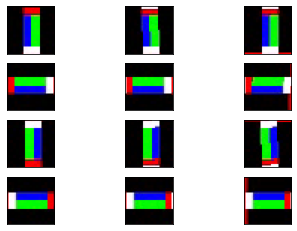

In [17]:
plt.figure()
for i in range(len(centers)):
    plt.subplot(4,3,i+1)
    plt.imshow(video[0][centers[i][0]-size_little_arm//2:centers[i][0]+size_little_arm//2,
            centers[i][1]-size_little_arm//2:centers[i][1]+size_little_arm//2,
            :])
    plt.tick_params(left = False , labelleft = False ,
                    labelbottom = False, bottom = False)



In [18]:
sig=np.diag([1,1])
N=100
l=0.001

v=video

newcenters=[]

for i in range(len(centers)):
   print(i,end=' ')
   p,v=Track_objet1(video=v,sigma=sig,N=N,Xinit=centers[i][0],Yinit=centers[i][1],size=size_little_arm,l=l,nbr_del=N//3)
   newcenters.append(p[-2])
   #p,v=New_tracking(video=v,sigma=sig,N=N,Xinit=centers[i][0],Yinit=centers[i][1],size=size_little_arm,l=1,nbr_del=N//3)



0 1 2 3 4 5 6 7 8 9 10 11 

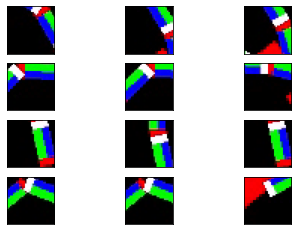

In [19]:
plt.figure()
for i in range(len(newcenters)):
    plt.subplot(4,3,i+1)
    plt.imshow(video[-2][newcenters[i][0]-size_little_arm//2:newcenters[i][0]+size_little_arm//2,
            newcenters[i][1]-size_little_arm//2:newcenters[i][1]+size_little_arm//2,
            :])
    plt.tick_params(left = False , labelleft = False ,
                    labelbottom = False, bottom = False)

Final position is not really good but we have to see the transition

In [20]:

height,width,layers=v[1].shape

#video=cv2.VideoWriter('video.avi',-1,1,(width,height))
video=cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))

for j in range(len(v)):
    video.write(v[j])

cv2.destroyAllWindows()
video.release()

cap = cv2.VideoCapture('project.avi')
while(1):
   ret,frame=cap.read()
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

In the video we can see that we can follow the arms but not really precisely, we need to change our parameters or use other methods

### Try with other video

In [21]:
# Clean video
video=[]
cap = cv2.VideoCapture('seq21.avi')
while(1):
   ret,frame=cap.read()
   video.append(frame)
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

(480, 640, 3)


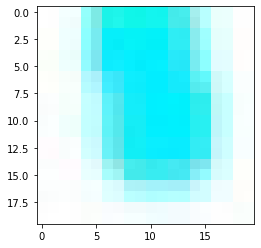

In [22]:
im=video[0]
p=[220,450]
t=10
print(im.shape)
plt.figure()
plt.imshow(im[p[0]-t:p[0]+t,p[1]-t:p[1]+t,:])
plt.show()

In [23]:
sigma=np.diag([10,10])
N=100
l=.1
points,v=black_Track_objet1(video=video,sigma=sigma,Xinit=p[0],Yinit=p[1],l=l,nbr_del=N//3,N=N,size=t)

height,width,layers=v[1].shape

#video=cv2.VideoWriter('video.avi',-1,1,(width,height))
videoWriter=cv2.VideoWriter('project2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))

for j in range(len(v)):
    videoWriter.write(v[j])

cv2.destroyAllWindows()
videoWriter.release()

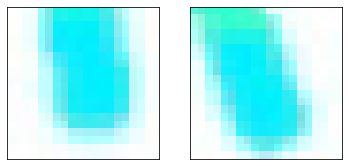

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(video[0][p[0]-t:p[0]+t,p[1]-t:p[1]+t,:])
plt.tick_params(left = False , labelleft = False ,
                    labelbottom = False, bottom = False)
plt.subplot(1,2,2)
plt.imshow(video[-2][points[-1][0]-t:points[-1][0]+t,points[-1][1]-t:points[-1][1]+t,:])
plt.tick_params(left = False , labelleft = False ,
                    labelbottom = False, bottom = False)
plt.show()

In [25]:
cap = cv2.VideoCapture('project2.avi')
while(1):
   ret,frame=cap.read()
   if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
      cap.release()
      cv2.destroyAllWindows()
      break
   cv2.imshow('frame',frame)

Different video different conclusion, the tracking is pretty bad but it ends well